## Observations and Insights

## Dependencies and starter code

In [118]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# Study data files
mouse_metadata = "data/Mouse_metadata.csv"
study_results = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata)
study_results = pd.read_csv(study_results)

# Combine the data into a single dataset
combined_df = pd.merge(mouse_metadata, study_results, on='Mouse ID', how='outer')
combined_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


## Summary statistics

In [304]:
# Generate a summary statistics table of mean, median, variance, 
#  standard deviation, and SEM of the tumor volume for each regimen.

# So first we will groupby Regimen
combined_groupedby_DR = combined_df.groupby('Drug Regimen')

# Then calculate our desired summary statistics
mean_df = pd.DataFrame(combined_groupedby_DR['Tumor Volume (mm3)'].mean())
median_df = pd.DataFrame(combined_groupedby_DR['Tumor Volume (mm3)'].median())
variance_df = pd.DataFrame(combined_groupedby_DR['Tumor Volume (mm3)'].var())
stdev_df = pd.DataFrame(combined_groupedby_DR['Tumor Volume (mm3)'].std())
sem_df = pd.DataFrame(combined_groupedby_DR['Tumor Volume (mm3)'].sem())

# Then merge them into one big datafframe
Summary_statistics_df = pd.merge(mean_df, median_df, on='Drug Regimen', suffixes=('_mean','_median'))
Summary_statistics_df = pd.merge(Summary_statistics_df, variance_df, on='Drug Regimen')
Summary_statistics_df = pd.merge(Summary_statistics_df, stdev_df, on='Drug Regimen', suffixes=('_variance','_stdev'))
Summary_statistics_df = pd.merge(Summary_statistics_df, sem_df, on='Drug Regimen')

# Rename the headers just because they were a little long before
Summary_statistics_df = Summary_statistics_df.rename(columns={
    'Tumor Volume (mm3)_mean': 'Mean', 
    'Tumor Volume (mm3)_median': 'Median',
    'Tumor Volume (mm3)_variance': 'Variance',
    'Tumor Volume (mm3)_stdev': 'St.Dev',
    'Tumor Volume (mm3)': 'SEM'})

# And finally display our df with a little formatting
Summary_statistics_df.apply(lambda x: round(x,2))

,Mean,Median,Variance,St.Dev,SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.32,50.85,42.35,6.51,0.51
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


## Bar plots

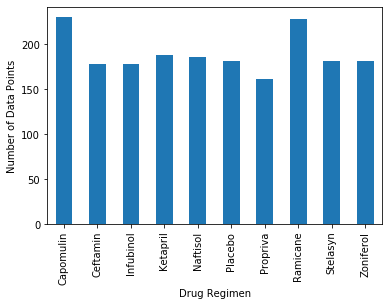

In [305]:
# Using Pandas, generate a bar plot showing number of data points 
#  for each treatment regimen

pandas_bar = combined_groupedby_DR.Timepoint.count().plot(kind='bar')
pandas_bar.set_ylabel('Number of Data Points')
plt.show()

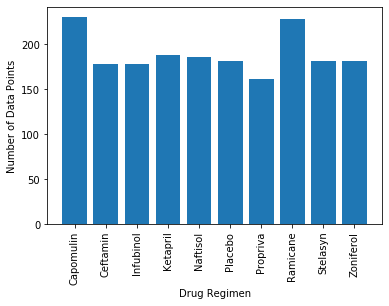

In [306]:
# Use PyPlot to do the same

x_axis = Summary_statistics_df['Mean'].keys() # 'Mean' could be any column
counts = combined_groupedby_DR.Timepoint.count() # 'Timepoint' could be any column

plt.bar(x_axis, counts)
plt.xticks(rotation=90)
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Data Points')
plt.show()

## Pie plots

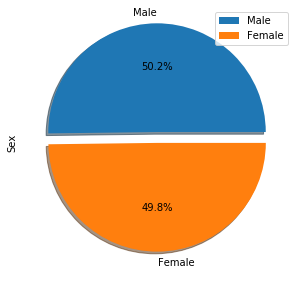

In [319]:
# Using Pandas, generate a pie plot showing the distribution of 
#  female versus male mice

combined_groupedby_ID = combined_df.groupby('Mouse ID')
combined_groupedby_ID_df = pd.DataFrame(combined_groupedby_ID.max())

gender_counts = combined_groupedby_ID_df.Sex.value_counts()
gender_counts_df = pd.DataFrame(gender_counts)

gender_counts_df.plot(kind='pie', figsize=(5,5), subplots=True, 
                      explode=(0.1,0),shadow=True, autopct="%1.1f%%")
plt.show()

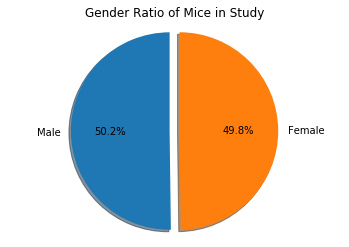

In [253]:
# Use PyPlot to do the same

plt.pie(gender_counts, explode=(0.1,0), 
        labels=['Male', 'Female'], autopct="%1.1f%%", 
        shadow=True, startangle=90)

plt.title('Gender Ratio of Mice in Study')
plt.axis('equal')
plt.show()

## Quartiles, outliers and boxplots

In [339]:
# Calculate the final tumor volume of each mouse 
#  across four of the most promising treatment regimens. 

# Starting with the same groupby df we used in the Pie plots section, 
#  we first resset the index so we can more easily use .loc
combined_final_df = combined_groupedby_ID_df.reset_index()

# Then filter out our 4 drugs of choice using .loc
combined_final_df = combined_final_df.loc[
    (combined_final_df['Drug Regimen'] == 'Ramicane')
       | (combined_final_df['Drug Regimen'] == 'Capomulin')
       | (combined_final_df['Drug Regimen'] == 'Propriva')
       | (combined_final_df['Drug Regimen'] == 'Ceftamin')]

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
quartiles = combined_final_df['Tumor Volume (mm3)'].quantile([0.25,0.5,0.75])
lowerq = quartiles[0.25]
median_final_tumor_vol = quartiles[0.5]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of final tumor volumes is: {round(lowerq,1)} cubic mm")
print(f"The the median of final tumor volumes is: {round(median_final_tumor_vol,1)} cubic mm")
print(f"The upper quartile of final tumor volumes is: {round(upperq,1)} cubic mm")
print(f"The interquartile range of final tumor volumes is: {round(iqr,1)} cubic mm")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)

if lower_bound > 0:
    print(f"Tumors below {round(lower_bound,1)} cubic mm could be outliers.")
else:
    pass
print(f"Tumors above {round(upper_bound,1)} cubic mm could be outliers.")

The lower quartile of final tumor volumes is: 45.5 cubic mm
The the median of final tumor volumes is: 46.9 cubic mm
The upper quartile of final tumor volumes is: 58.5 cubic mm
The interquartile range of final tumor volumes is: 13.0 cubic mm
Tumors below 26.1 cubic mm could be outliers.
Tumors above 77.9 cubic mm could be outliers.


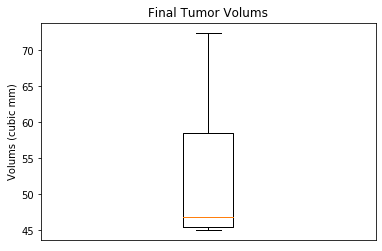

In [340]:
# Generate a box plot of the final tumor volume of each mouse across 
#  the four regimens of interest
plt.boxplot(combined_final_df['Tumor Volume (mm3)'])
plt.title('Final Tumor Volums')
plt.xticks([0]) # this is just to get rid of the single tick beneath the boxplot
plt.ylabel('Volums (cubic mm)') 
plt.show()

## Line and scatter plots

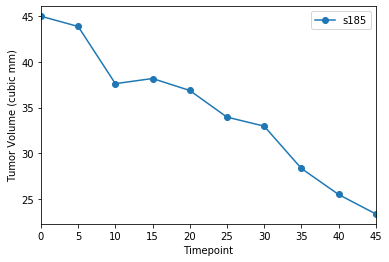

In [342]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin

# choose the mouse
s185_df = combined_df.loc[(combined_df['Mouse ID'] == 's185')]

# set Timepoint to be our index (x_axis)
s185_df = s185_df.set_index('Timepoint')

# shrink our dataframe to only tumor volume (y_axis)
s185_df = s185_df['Tumor Volume (mm3)']

s185_df.plot(kind='line', marker='o', label='s185')
plt.ylabel('Tumor Volume (cubic mm)')
plt.legend(loc='best')
plt.show()

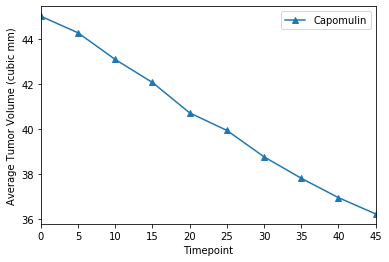

In [343]:
# I'm going do the average Capomulin mouse's tumor volume as it's more representative

# choose a drug
Capomulin_df = combined_df.loc[(combined_df['Drug Regimen'] == 'Capomulin')]

# set Timepoint to be our index (x_axis)
Capomulin_groupedby_Timepoint = Capomulin_df.groupby('Timepoint')

# plot only the tumor volume (y_axis)
Capomulin_groupedby_Timepoint.mean()['Tumor Volume (mm3)'].plot(
    kind='line', marker='^', label='Capomulin')
plt.ylabel('Average Tumor Volume (cubic mm)')
plt.legend(loc='best')
plt.show()

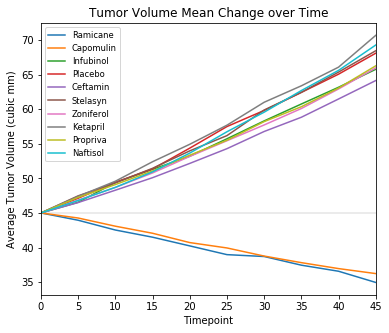

In [344]:
# You know, while we're at it, let's just plot them all!

# We want a specific ratio to see the spread of data
plt.figure(figsize=(6,5))

# This get's a little ugly but it's mainly just copy.pasting what is above
#  and putting it all into one big line of list comprehension
[combined_df.loc[(combined_df['Drug Regimen'] == str(drug))].groupby('Timepoint').mean()['Tumor Volume (mm3)'].plot(
    kind='line', label=str(drug)) for drug in list(combined_df['Drug Regimen'].unique())]

# Adding an hline so we can see where every tumor starts
plt.hlines(45, 0, 45, alpha=0.1)

plt.ylabel('Average Tumor Volume (cubic mm)')
plt.legend(loc='upper left',fontsize="small")
plt.title('Tumor Volume Mean Change over Time')
plt.show()
# We can see that all but two drugs are no better or worse than the Placebo

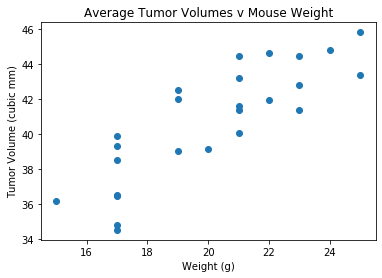

In [266]:
# Generate a scatter plot of mouse weight versus average tumor volume 
#  for the Capomulin regimen

# We start by groping just the Capomulin dataframe we used above by ID 
Capomulin_groupedby_ID = Capomulin_df.groupby('Mouse ID')
# Then make a new dataframe of the averages (because we'll want the ave volume)
Capomulin_groupedby_ID_mean_df = pd.DataFrame(Capomulin_groupedby_ID.mean())

# Calculate the desired points
weights = Capomulin_groupedby_ID_mean_df['Weight (g)']
ave_volumes =  Capomulin_groupedby_ID_mean_df['Tumor Volume (mm3)']

plt.scatter(weights, ave_volumes)
plt.title('Average Tumor Volumes v Mouse Weight')
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (cubic mm)')
plt.show()


The correlation between weight and tumor size is 0.84


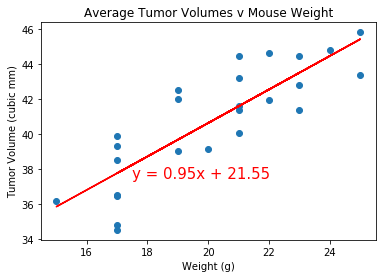

In [277]:
# Calculate the correlation coefficient and linear regression model 
#  for mouse weight and average tumor volume for the Capomulin regimen

correlation = st.pearsonr(weights, ave_volumes)
print(f"The correlation between weight and tumor size is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = st.linregress(weights, ave_volumes)
regress_values = weights * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(weights, ave_volumes)
plt.plot(weights,regress_values,"r-")
plt.annotate(line_eq,(17.5,37.5),fontsize=15,color="red")
plt.title('Average Tumor Volumes v Mouse Weight')
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (cubic mm)')
plt.show()